# Imports:

In [2]:
# Makes sure to reload modules when they change
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.amp import GradScaler, autocast
import joblib
from tqdm import tqdm
from PIL import Image, ImageOps

# --- CUSTOM IMPORTS ---
from src.utils import extractCoordinates, aspect_crop, haversine_distance, plot_images_from_dataloader
from src.dataset import GeolocalizationDataset
from src.models import ConvNet, ConvNet2, ConvNet3

torch.backends.cudnn.benchmark = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Image preprocessing:

In [3]:
# Setup paths
RAW_IMAGE_FOLDER = r"data"             # Use original images for GPS extraction
PROCESSED_IMAGE_FOLDER = r"data_processed" # Use processed images for training

if not os.path.exists(PROCESSED_IMAGE_FOLDER) or len(os.listdir(PROCESSED_IMAGE_FOLDER)) < 1479:
    os.makedirs(PROCESSED_IMAGE_FOLDER, exist_ok=True)

    print("Starting Pre-processing...")
    files = [f for f in os.listdir(RAW_IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg'))]

    for filename in tqdm(files):
        src_path = os.path.join(RAW_IMAGE_FOLDER, filename)
        dst_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
        
        try:
            with Image.open(src_path) as img:
                img = ImageOps.exif_transpose(img)
                img = img.convert('RGB')
                img = aspect_crop(img) 
                img = img.resize((192, 256), Image.Resampling.LANCZOS)
                img.save(dst_path, quality=95)
        except Exception as e:
            print(f"Failed {filename}: {e}")
else:
    print("Pre-processed images already exist. Skipping preprocessing step.")

Pre-processed images already exist. Skipping preprocessing step.


# Data loading:

In [4]:
if __name__ == "__main__":

    SCALER_SAVE_PATH = 'coordinate_scaler.pkl'

    # --- 2. EXTRACTION PHASE ---
    processed_data = []

    for filename in os.listdir(RAW_IMAGE_FOLDER):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            raw_image_path = os.path.join(RAW_IMAGE_FOLDER, filename)
            processed__image_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
            
            # Check if the processed version actually exists
            if not os.path.exists(processed__image_path):
                continue
                
            # Extract coordinates from the ORIGINAL file
            coords = extractCoordinates(raw_image_path)
            
            if coords:
                processed_data.append({
                    'path': processed__image_path, 
                    'lat': coords[0], 
                    'lon': coords[1]
                })

    df = pd.DataFrame(processed_data)
    
    # Keep 20% of the data for validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # --- 3. SCALING PHASE ---
    # must fit on training data *only*
    scaler = MinMaxScaler()
    train_df[['lat', 'lon']] = scaler.fit_transform(train_df[['lat', 'lon']])
    val_df[['lat', 'lon']] = scaler.transform(val_df[['lat', 'lon']])

    joblib.dump(scaler, SCALER_SAVE_PATH)

Initializing train dataset...
Caching 1183 images in RAM...


100%|██████████| 1183/1183 [00:01<00:00, 638.13it/s]


Initializing validation dataset...
Caching 296 images in RAM...


100%|██████████| 296/296 [00:00<00:00, 631.59it/s]


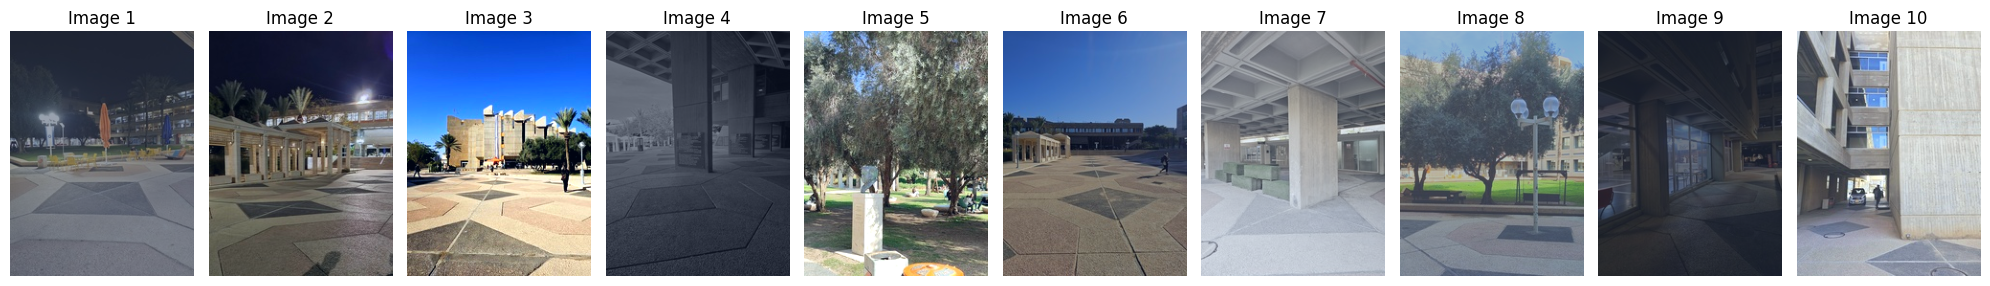

In [5]:
if __name__ == "__main__":

    # --- 4. DATASET INITIALIZATION ---
    print("Initializing train dataset...")
    train_dataset = GeolocalizationDataset(
        image_paths=train_df['path'].tolist(),
        coordinates=train_df[['lat', 'lon']].values,
        is_train=True
    )
    print("Initializing validation dataset...")
    val_dataset = GeolocalizationDataset(
        image_paths=val_df['path'].tolist(),
        coordinates=val_df[['lat', 'lon']].values,
        is_train=False
    )

    # --- 5. THE DATALOADER ---
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0, #todo: tal try 4
        # persistent_workers=True,
        pin_memory=True)
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0, #todo: tal try 4
        # persistent_workers=True,
        pin_memory=False)
    
    plot_images_from_dataloader(train_loader)

# Model setup:

In [17]:
# --- 6. INITIALIZE MODEL ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_rtx = "RTX" in torch.cuda.get_device_name(0)
print("Using device:", device)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

model = ConvNet2(use_dropout=True).to(device)

if is_rtx:
    model = model.to(memory_format=torch.channels_last) # Optimize for modern GPUs that prefer channels_last
else:
    print("RTX card not detected: Disabling AMP/Channels_Last optimizations")
    model = model.to(device)

# --- 7. LOSS & OPTIMIZER ---
patience_counter = 0
early_stopping_patience = 10
epochs = 100

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=1e-3, 
    steps_per_epoch=len(train_loader), 
    epochs=epochs,
    pct_start=0.3, # Spend 30% of time warming up
    div_factor=25, # Start at max_lr / 25
    final_div_factor=1e4 # End at max_lr / 10000
)

print(f"Training on {len(train_dataset)} images, Validating on {len(val_dataset)} images.")

Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce GTX 1070
RTX card not detected: Disabling AMP/Channels_Last optimizations
Training on 1183 images, Validating on 296 images.


# Model training:

In [18]:
# --- 8. TRAINING & VALIDATION LOOP ---
train_losses = []
val_losses = []
val_dist_history = []
best_dist = float("inf")

print(f"Starting training on {device}...")

gradScaler = GradScaler('cuda') #scaler for mixed precision training, prevents gradient underflow

for epoch in tqdm(range(epochs) , desc="Epochs", unit="epoch"):
    # --- PHASE 1: TRAINING ---
    model.train()  # Dropout ON
    train_running_loss = 0.0

    for images, labels in train_loader:
        # non_blocking=True speeds up RAM-to-VRAM transfer
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        if is_rtx: # Optimize for RTX GPUs that prefer channels_last
            images = images.to(memory_format=torch.channels_last)

        optimizer.zero_grad(set_to_none=True)

        if is_rtx: # Use Mixed Precision Training only on RTX cards
            with autocast('cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

            gradScaler.scale(loss).backward() 
            gradScaler.step(optimizer)        
            gradScaler.update()  

        else: # Standard training for non-RTX cards
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        scheduler.step() # OneCycleLR steps after every batch
        train_running_loss += loss.item()

    # --- PHASE 2: VALIDATION ---
    model.eval()  # Set model to evaluation mode (disables Dropout)
    val_running_loss = 0.0
    total_distance = 0.0
    correct_50m = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # 1. Standard Prediction and MSE Loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # 2. Get Real-World Coordinates for Physical Metrics
            # Convert normalized predictions and labels back to GPS
            pred_normalized = outputs.cpu().numpy()
            true_normalized = labels.cpu().numpy()

            real_preds = scaler.inverse_transform(pred_normalized)  #
            real_trues = scaler.inverse_transform(true_normalized)  #

            # 3. Calculate Physical Distance Error
            distances = haversine_distance(real_preds, real_trues)

            # 4. Accumulate Statistics
            total_distance += np.sum(distances)
            correct_50m += np.sum(distances < 50)  # Count hits within 50m
            total_samples += len(labels)

    # --- PHASE 3: METRICS CALCULATION & PRINTING ---
    avg_train_loss = train_running_loss / len(train_loader)
    avg_val_loss = val_running_loss / len(val_loader)

    # Physical Metrics
    avg_dist_error = total_distance / total_samples  # Average error in meters
    accuracy_50m = (correct_50m / total_samples) * 100  # % Success rate

    # Keep history for plots
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_dist_history.append(avg_dist_error)

    # Log results
    print(f"Epoch [{epoch + 1}/{epochs}]")
    print(f"  -> Loss (MSE): Train {avg_train_loss:.6f} | Val {avg_val_loss:.6f}")
    print(
        f"  -> Reality: Avg Error {avg_dist_error:.1f}m | Accuracy@50m: {accuracy_50m:.1f}%"
    )
    print("-" * 30)

    # 2. Save the BEST version of YOUR model
    if avg_dist_error < best_dist:
        best_dist = avg_dist_error
        torch.save(model.state_dict(), "custom_geo_model_best.pth")
        patience_counter = 0
        print(f"  *** NEW BEST: {best_dist:.1f}m ***")
    else:
        patience_counter += 1
        print(
            f"  (No improvement for {patience_counter}/{early_stopping_patience} epochs)"
        )

    print("-" * 30)

    # 3. Early Stopping check
    if patience_counter >= early_stopping_patience:
        print("Model stopped improving. Ending training early.")
        break 

Starting training on cuda...


Epochs:   1%|          | 1/100 [00:06<10:40,  6.47s/epoch]

Epoch [1/100]
  -> Loss (MSE): Train 0.097341 | Val 0.070944
  -> Reality: Avg Error 87.6m | Accuracy@50m: 27.7%
------------------------------
  *** NEW BEST: 87.6m ***
------------------------------


Epochs:   2%|▏         | 2/100 [00:12<10:13,  6.26s/epoch]

Epoch [2/100]
  -> Loss (MSE): Train 0.067810 | Val 0.057275
  -> Reality: Avg Error 79.8m | Accuracy@50m: 35.8%
------------------------------
  *** NEW BEST: 79.8m ***
------------------------------


Epochs:   3%|▎         | 3/100 [00:18<09:54,  6.13s/epoch]

Epoch [3/100]
  -> Loss (MSE): Train 0.066314 | Val 0.056211
  -> Reality: Avg Error 79.6m | Accuracy@50m: 31.8%
------------------------------
  *** NEW BEST: 79.6m ***
------------------------------


Epochs:   4%|▍         | 4/100 [00:24<09:42,  6.07s/epoch]

Epoch [4/100]
  -> Loss (MSE): Train 0.060894 | Val 0.057334
  -> Reality: Avg Error 75.4m | Accuracy@50m: 41.6%
------------------------------
  *** NEW BEST: 75.4m ***
------------------------------


Epochs:   5%|▌         | 5/100 [00:32<10:28,  6.62s/epoch]

Epoch [5/100]
  -> Loss (MSE): Train 0.057924 | Val 0.052780
  -> Reality: Avg Error 73.1m | Accuracy@50m: 41.6%
------------------------------
  *** NEW BEST: 73.1m ***
------------------------------


Epochs:   6%|▌         | 6/100 [00:37<09:56,  6.35s/epoch]

Epoch [6/100]
  -> Loss (MSE): Train 0.058191 | Val 0.052953
  -> Reality: Avg Error 70.9m | Accuracy@50m: 45.6%
------------------------------
  *** NEW BEST: 70.9m ***
------------------------------


Epochs:   7%|▋         | 7/100 [00:43<09:23,  6.05s/epoch]

Epoch [7/100]
  -> Loss (MSE): Train 0.057338 | Val 0.055113
  -> Reality: Avg Error 71.7m | Accuracy@50m: 47.0%
------------------------------
  (No improvement for 1/10 epochs)
------------------------------


Epochs:   8%|▊         | 8/100 [00:49<09:18,  6.07s/epoch]

Epoch [8/100]
  -> Loss (MSE): Train 0.055422 | Val 0.054362
  -> Reality: Avg Error 70.8m | Accuracy@50m: 45.9%
------------------------------
  *** NEW BEST: 70.8m ***
------------------------------


Epochs:   9%|▉         | 9/100 [00:56<09:25,  6.21s/epoch]

Epoch [9/100]
  -> Loss (MSE): Train 0.056083 | Val 0.065502
  -> Reality: Avg Error 78.7m | Accuracy@50m: 41.6%
------------------------------
  (No improvement for 1/10 epochs)
------------------------------


Epochs:  10%|█         | 10/100 [01:02<09:18,  6.20s/epoch]

Epoch [10/100]
  -> Loss (MSE): Train 0.056855 | Val 0.049977
  -> Reality: Avg Error 72.0m | Accuracy@50m: 37.5%
------------------------------
  (No improvement for 2/10 epochs)
------------------------------


Epochs:  11%|█         | 11/100 [01:08<09:13,  6.22s/epoch]

Epoch [11/100]
  -> Loss (MSE): Train 0.052877 | Val 0.081107
  -> Reality: Avg Error 87.8m | Accuracy@50m: 42.2%
------------------------------
  (No improvement for 3/10 epochs)
------------------------------


Epochs:  12%|█▏        | 12/100 [01:14<08:55,  6.09s/epoch]

Epoch [12/100]
  -> Loss (MSE): Train 0.055598 | Val 0.064898
  -> Reality: Avg Error 75.4m | Accuracy@50m: 48.3%
------------------------------
  (No improvement for 4/10 epochs)
------------------------------


Epochs:  13%|█▎        | 13/100 [01:20<08:45,  6.04s/epoch]

Epoch [13/100]
  -> Loss (MSE): Train 0.053296 | Val 0.048711
  -> Reality: Avg Error 72.4m | Accuracy@50m: 36.1%
------------------------------
  (No improvement for 5/10 epochs)
------------------------------


Epochs:  14%|█▍        | 14/100 [01:25<08:32,  5.96s/epoch]

Epoch [14/100]
  -> Loss (MSE): Train 0.053602 | Val 0.058267
  -> Reality: Avg Error 74.9m | Accuracy@50m: 41.9%
------------------------------
  (No improvement for 6/10 epochs)
------------------------------


Epochs:  15%|█▌        | 15/100 [01:32<08:28,  5.99s/epoch]

Epoch [15/100]
  -> Loss (MSE): Train 0.051675 | Val 0.063895
  -> Reality: Avg Error 80.1m | Accuracy@50m: 35.5%
------------------------------
  (No improvement for 7/10 epochs)
------------------------------


Epochs:  16%|█▌        | 16/100 [01:38<08:36,  6.15s/epoch]

Epoch [16/100]
  -> Loss (MSE): Train 0.053077 | Val 0.052491
  -> Reality: Avg Error 75.2m | Accuracy@50m: 38.2%
------------------------------
  (No improvement for 8/10 epochs)
------------------------------


Epochs:  17%|█▋        | 17/100 [01:44<08:26,  6.11s/epoch]

Epoch [17/100]
  -> Loss (MSE): Train 0.051277 | Val 0.046890
  -> Reality: Avg Error 65.6m | Accuracy@50m: 45.3%
------------------------------
  *** NEW BEST: 65.6m ***
------------------------------


Epochs:  18%|█▊        | 18/100 [01:50<08:11,  6.00s/epoch]

Epoch [18/100]
  -> Loss (MSE): Train 0.051233 | Val 0.048859
  -> Reality: Avg Error 67.4m | Accuracy@50m: 50.7%
------------------------------
  (No improvement for 1/10 epochs)
------------------------------


Epochs:  19%|█▉        | 19/100 [01:56<08:07,  6.02s/epoch]

Epoch [19/100]
  -> Loss (MSE): Train 0.052461 | Val 0.044859
  -> Reality: Avg Error 63.8m | Accuracy@50m: 49.3%
------------------------------
  *** NEW BEST: 63.8m ***
------------------------------


Epochs:  19%|█▉        | 19/100 [02:01<08:37,  6.39s/epoch]


KeyboardInterrupt: 

# Plotting the results:

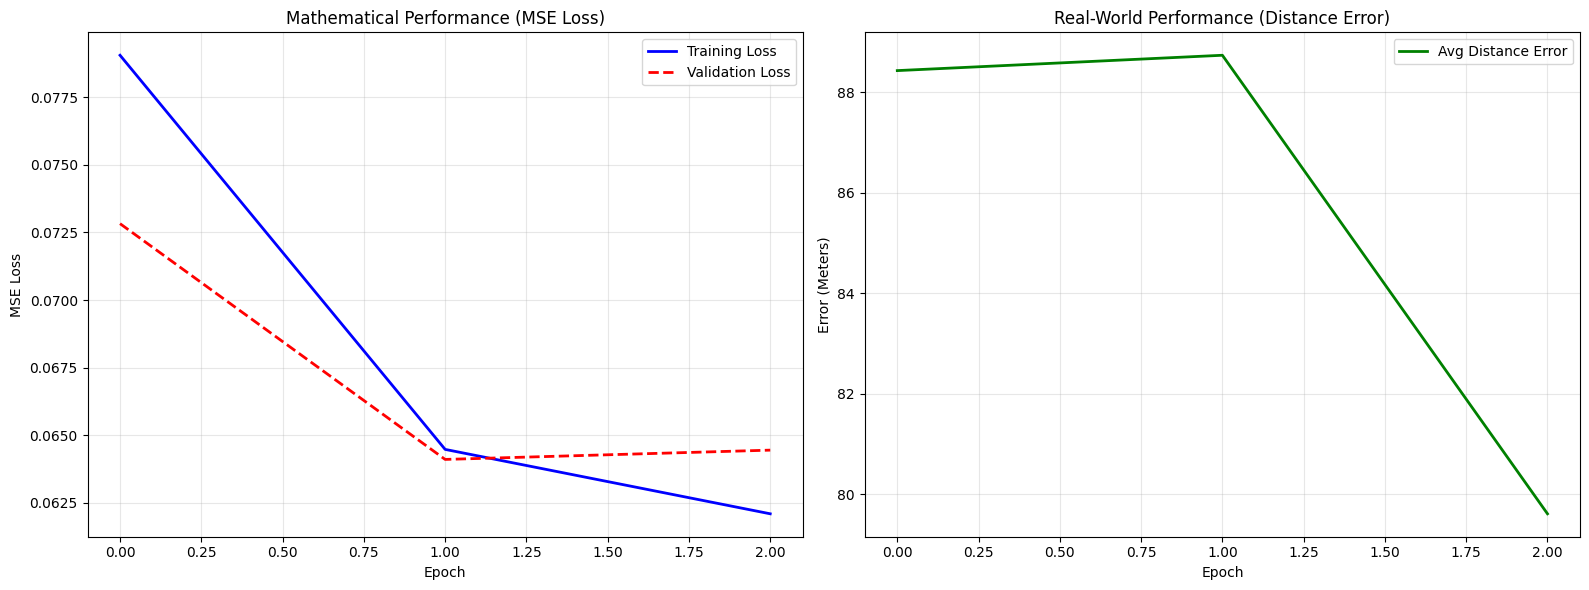


Training finished! Best Validation Error: 79.6 meters.
Model saved as 'geo_model.pth'


In [ ]:
# --- 9. SAVE THE MODEL & GENERATE PLOTS ---

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: MSE Loss (Training vs Validation)
ax1.plot(train_losses, label="Training Loss", color="blue", linewidth=2)
ax1.plot(val_losses, label="Validation Loss", color="red", linestyle="--", linewidth=2)
ax1.set_title("Mathematical Performance (MSE Loss)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right Plot: Physical Distance Error (Meters)
ax2.plot(val_dist_history, label="Avg Distance Error", color="green", linewidth=2)
ax2.set_title("Real-World Performance (Distance Error)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Error (Meters)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the model weights
torch.save(model.state_dict(), "geo_model.pth")
print(f"\nTraining finished! Best Validation Error: {best_dist:.1f} meters.")
print("Model saved as 'geo_model.pth'")

In [ ]:
""" # Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCALER_PATH = 'coordinate_scaler.pkl'
MODEL_WEIGHTS_PATH = 'geo_model.pth'

# Loading Model and Scaler
# Initialize the model architecture and move to the device (GPU/CPU)
model = ConvNet2().to(device)

# Load the trained weights from the .pth file
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

# Set the model to evaluation mode (disables Dropout and Batchnorm layers)
model.eval()

# Load the MinMaxScaler used during training to reverse the normalization
scaler = joblib.load(SCALER_PATH)

# Image Preprocessing Function
def predict_location(image_path):

    # Load the image and ensure it is in RGB format
    img = Image.open(image_path).convert('RGB')
    
    # Apply the same validation transforms (No augmentations here!)
    preprocess = T.Compose([
        T.Resize(256),
        T.CenterCrop(256),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Add a batch dimension (Batch size of 1) and move the tensor to device
    img_tensor = preprocess(img).unsqueeze(0).to(device) 
    
    # Perform inference without calculating gradients
    with torch.no_grad():
        output = model(img_tensor)
    
    # Convert the prediction back to a NumPy array on the CPU
    prediction_normalized = output.cpu().numpy()
    
    # Reverse the scaling to get real-world GPS coordinates
    real_coords = scaler.inverse_transform(prediction_normalized)
    
    # Return the first (and only) result in the batch [Latitude, Longitude]
    return real_coords[0]

# Run Inference on a New Image
# Provide the full path to your local image file
test_path = r"C:\path\to\your\new\image.jpg"
lat, lon = predict_location(test_path)

print(f"Predicted Location: Latitude {lat:.6f}, Longitude {lon:.6f}")
print(f"Google Maps Link: http://maps.google.com/maps?q={lat},{lon}") """

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\013ri\AppData\Local\Temp\ipykernel_19632\333207449.py:1: SyntaxWarning: invalid escape sequence '\p'
  """ # Check if GPU is available, otherwise use CPU


' # Check if GPU is available, otherwise use CPU\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nSCALER_PATH = \'coordinate_scaler.pkl\'\nMODEL_WEIGHTS_PATH = \'geo_model.pth\'\n\n# Loading Model and Scaler\n# Initialize the model architecture and move to the device (GPU/CPU)\nmodel = ConvNet2().to(device)\n\n# Load the trained weights from the .pth file\nmodel.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))\n\n# Set the model to evaluation mode (disables Dropout and Batchnorm layers)\nmodel.eval()\n\n# Load the MinMaxScaler used during training to reverse the normalization\nscaler = joblib.load(SCALER_PATH)\n\n# Image Preprocessing Function\ndef predict_location(image_path):\n\n    # Load the image and ensure it is in RGB format\n    img = Image.open(image_path).convert(\'RGB\')\n\n    # Apply the same validation transforms (No augmentations here!)\n    preprocess = T.Compose([\n        T.Resize(256),\n        T.CenterCrop(256),\n        T.ToTensor(),\n        